# Pneumonia Detection through X-Rays
A convolutional neural network (CNN) model for detecting pneumonia in chest X-ray images, aimed at automating and improving medical diagnostics.

In [2]:
# Basic Libraries
import numpy as np
import pandas as pd
import os

# Image Processing and Visualization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Metrics and Evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Setting a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation and Loading
This sets up the path to the dataset directories, initializes an ImageDataGenerator for image normalization, and loads the training, validation, and test datasets with images resized to 224x224 pixels and labeled for binary classification.



In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths for train, validation, and test directories
train_dir = '/content/drive/My Drive/chest_xray/train'
val_dir = '/content/drive/My Drive/chest_xray/val'
test_dir = '/content/drive/My Drive/chest_xray/test'

# Initialize ImageDataGenerator for preprocessing
data_gen = ImageDataGenerator(rescale=1.0/255)  # Normalize pixel values

# Load the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


validation_generator = data_gen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = data_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# EXPLORATORY DATA ANALYSIS

## Checking if there is any Imbalance between the 'NORMAL' and 'PNEUMONIA CLASSES'

In [5]:
import os

def count_images(directory):
    normal_count = len(os.listdir(os.path.join(directory, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return normal_count, pneumonia_count

train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

print("Training set - NORMAL:", train_normal, "PNEUMONIA:", train_pneumonia)
print("Validation set - NORMAL:", val_normal, "PNEUMONIA:", val_pneumonia)
print("Test set - NORMAL:", test_normal, "PNEUMONIA:", test_pneumonia)


Training set - NORMAL: 1341 PNEUMONIA: 3875
Validation set - NORMAL: 8 PNEUMONIA: 8
Test set - NORMAL: 234 PNEUMONIA: 390


## Sample Image Visualisation
This counts and displays the number of images in each class for the train, validation, and test sets.

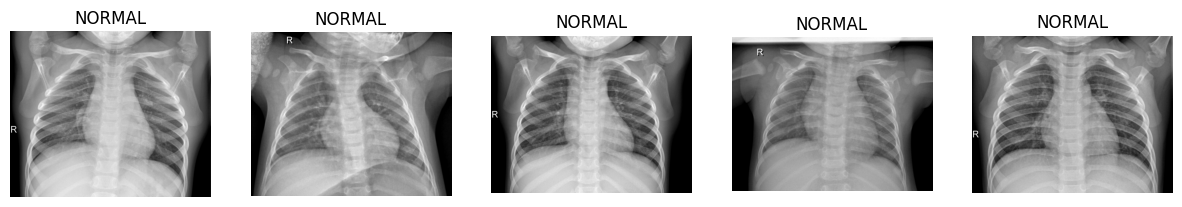

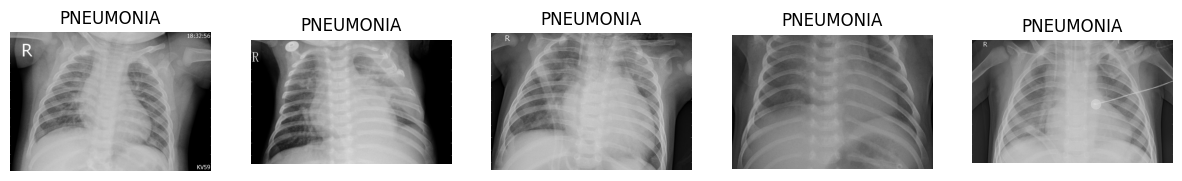

In [6]:
import matplotlib.pyplot as plt
import cv2
import random

def plot_samples(directory, label, num_images=5):
    folder = os.path.join(directory, label)
    images = random.sample(os.listdir(folder), num_images)
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    plt.show()

plot_samples(train_dir, 'NORMAL')
plot_samples(train_dir, 'PNEUMONIA')


# Cleaning and Validating Image Files
This removes any non-image and corrupted files from the training, validation, and test directories to ensure only valid images are used for model training and evaluation.

In [4]:
import os

# Define a function to delete unwanted files
def remove_non_image_files(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if not (file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png')):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed non-image file: {file_path}")

# Apply this function to each directory
remove_non_image_files(train_dir)
remove_non_image_files(val_dir)
remove_non_image_files(test_dir)


def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Check if image can be opened
            except (IOError, SyntaxError) as e:
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)  # Remove unreadable files

# Validate images in each directory
validate_images(train_dir)
validate_images(val_dir)
validate_images(test_dir)


# Build and Compile the CNN Model with Transfer Learning
This uses the VGG16 pre-trained model as a base, adds custom layers for binary classification, and compiles the model with a low learning rate for fine-tuning on the pneumonia dataset.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a simple CNN model with the updated input shape
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Updated input shape
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training the Model
This trains the model on the training data while monitoring validation performance for 10 epochs.



In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 1873s 11s/step - accuracy: 0.7533 - loss: 0.5379 - val_accuracy: 0.6250 - val_loss: 0.6727
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6727
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 682s 4s/step - accuracy: 0.8309 - loss: 0.3514 - val_accuracy: 0.6875 - val_loss: 0.9798
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.9798
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 675s 4s/step - accuracy: 0.8537 - loss: 0.3205 - val_accuracy: 0.6250 - val_loss: 1.0136
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.0136
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 664s 4s/step - accuracy: 0.8721 - loss: 0.2877 - val_accuracy: 0.6250 - val_loss: 0.6732
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6732
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 687s 4s/step - accuracy: 0.8829 - loss: 

# Visualizing Training and Validation Performance
This defines a function to plot the model's training and validation accuracy and loss over 10 epochs, helping to assess model performance and check for overfitting.

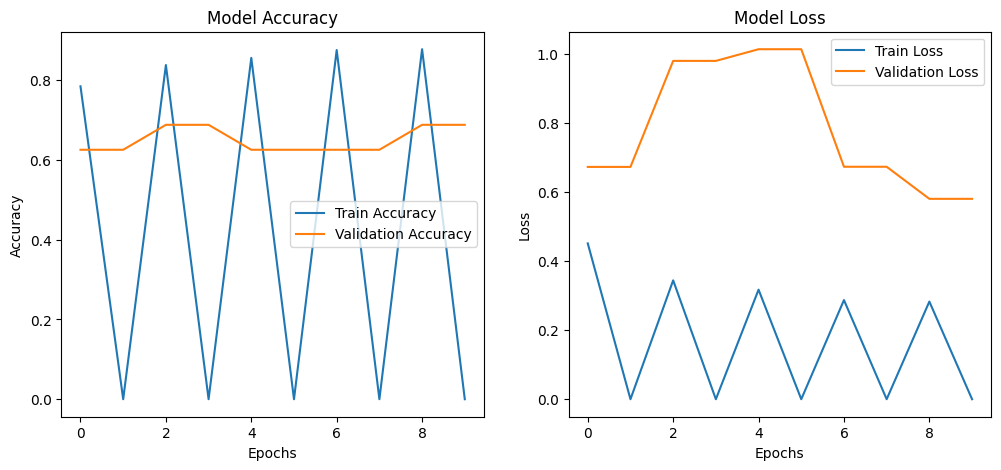

In [10]:
import matplotlib.pyplot as plt

# Function to plot the training history
def plot_training_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Use this function with your training history
plot_training_history(history)


## Evaluating on the Test Set

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 219s 12s/step - accuracy: 0.8780 - loss: 0.3933
Test Accuracy: 85.86%


In [12]:
print(test_loss)

0.3554082214832306


## Getting a classification report

In [13]:
from sklearn.metrics import classification_report

# Get predictions on the test set
predictions = model.predict(test_generator, steps=None)

# Convert probabilities to binary classes
predicted_classes = (predictions > 0.5).astype("int32")

# Get true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step
              precision    recall  f1-score   support

      NORMAL       0.77      0.88      0.82       234
   PNEUMONIA       0.92      0.84      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.86      0.85       624
weighted avg       0.87      0.86      0.86       624



# Saving the Model using Pickle

In [14]:
# Save the model in TensorFlow's SavedModel format
model.save("pneumonia_detection_model.keras")

In [15]:
# Load the saved model
model = tf.keras.models.load_model("pneumonia_detection_model.keras")

## Testing the model in real time
We run a bunch of images through the model to see how well it works in real time.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


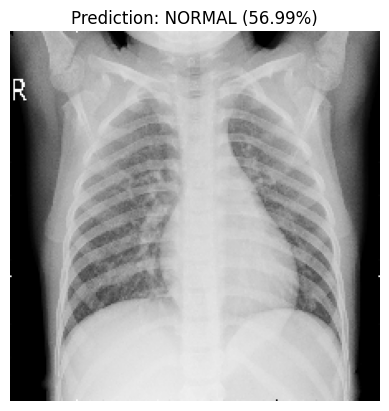

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


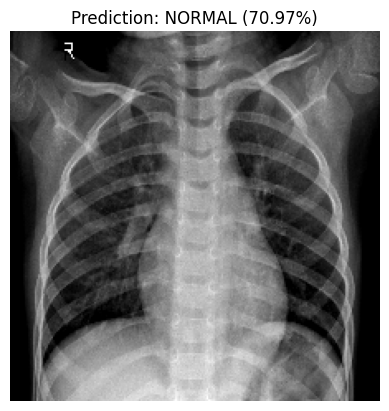

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


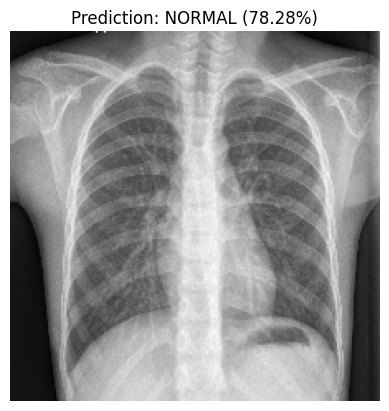

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


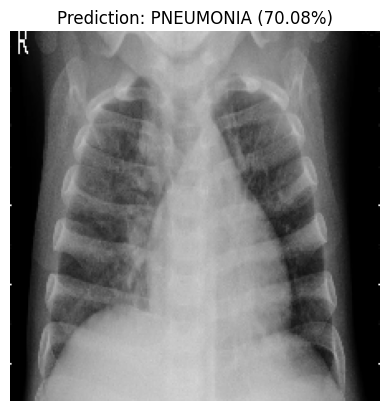

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


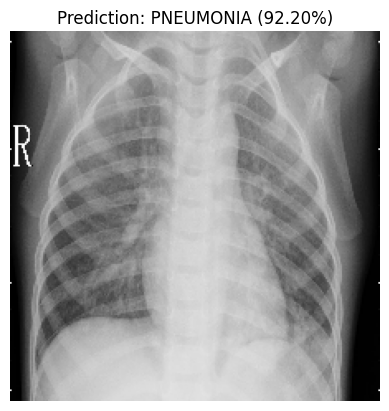

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


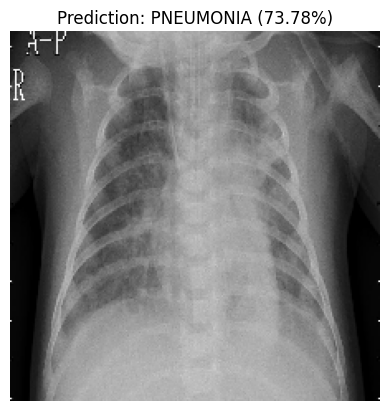

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def display_prediction(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))  # Resize to model's expected input
    img_array = image.img_to_array(img)                       # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)             # Add batch dimension
    img_array /= 255.0                                        # Normalize to [0,1]

    # Make a prediction
    prediction = model.predict(img_array)
    class_label = "PNEUMONIA" if prediction[0][0] > 0.5 else "NORMAL"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {class_label} ({confidence*100:.2f}%)")
    plt.show()

image_path = 'val_normal1.jpeg'
display_prediction(image_path, model)

image_path = 'val_normal2.jpeg'
display_prediction(image_path, model)

image_path = 'test_pneumonia1.jpeg'
display_prediction(image_path, model)

image_path = 'test_pneumonia2.jpeg'
display_prediction(image_path, model)

image_path = 'val_pneumonia1.jpeg'
display_prediction(image_path, model)

image_path = 'val_pneumonia2.jpeg'
display_prediction(image_path, model)